In [2]:
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier
from time import time
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
path = 'D:\\Users\\cqgator\\Desktop' #'C:\Users\Charlie2\Documents\pubg stat'
filename_sample = path + '\\sample_submission_V2.csv'
filename_test = path + '\\test_V2.csv'
filename_train = path + '\\train_V2.csv'
#test_data = pd.read_csv(filename_test)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
# REMEMBER to add the engineered features to the test set as well

In [4]:
filename_train

'D:\\Users\\cqgator\\Desktop\\train_V2.csv'

In [5]:
train_data = pd.read_csv(filename_train)

In [6]:
train_data.describe()

,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
count,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,...,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446965e+06
mean,2.338149e-01,1.106908e+00,1.307171e+02,6.578755e-01,2.268196e-01,1.370147e+00,4.759935e+01,5.050060e+02,9.247833e-01,5.439551e-01,...,1.646590e-01,6.061157e+02,3.496091e-03,4.509322e+00,2.386841e-02,7.918208e-03,1.154218e+03,3.660488e+00,6.064601e+02,4.728216e-01
std,5.885731e-01,1.715794e+00,1.707806e+02,1.145743e+00,6.021553e-01,2.679982e+00,2.746294e+01,6.275049e+02,1.558445e+00,7.109721e-01,...,4.721671e-01,1.498344e+03,7.337297e-02,3.050220e+01,1.673935e-01,9.261157e-02,1.183497e+03,2.456544e+00,7.397004e+02,3.074050e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.400000e+01,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.551000e+02,2.000000e+00,0.000000e+00,2.000000e-01
50%,0.000000e+00,0.000000e+00,8.424000e+01,0.000000e+00,0.000000e+00,0.000000e+00,4.700000e+01,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.856000e+02,3.000000e+00,0.000000e+00,4.583000e-01
75%,0.000000e+00,2.000000e+00,1.860000e+02,1.000000e+00,0.000000e+00,2.000000e+00,7.100000e+01,1.172000e+03,1.000000e+00,1.000000e+00,...,0.000000e+00,1.909750e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.976000e+03,5.000000e+00,1.495000e+03,7.407000e-01
max,2.200000e+01,3.300000e+01,6.616000e+03,5.300000e+01,6.400000e+01,8.000000e+01,1.010000e+02,2.170000e+03,7.200000e+01,2.000000e+01,...,3.900000e+01,4.071000e+04,1.800000e+01,3.823000e+03,1.200000e+01,5.000000e+00,2.578000e+04,2.360000e+02,2.013000e+03,1.000000e+00


In [7]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4446966 entries, 0 to 4446965
Data columns (total 29 columns):
Id                 object
groupId            object
matchId            object
assists            int64
boosts             int64
damageDealt        float64
DBNOs              int64
headshotKills      int64
heals              int64
killPlace          int64
killPoints         int64
kills              int64
killStreaks        int64
longestKill        float64
matchDuration      int64
matchType          object
maxPlace           int64
numGroups          int64
rankPoints         int64
revives            int64
rideDistance       float64
roadKills          int64
swimDistance       float64
teamKills          int64
vehicleDestroys    int64
walkDistance       float64
weaponsAcquired    int64
winPoints          int64
winPlacePerc       float64
dtypes: float64(6), int64(19), object(4)
memory usage: 983.9+ MB


In [8]:
# Let's start validating data by making sure every player placed at the end of the match
# Let's check for a row with a NaN value in that column.
train_data[train_data['winPlacePerc'].isnull()]

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
2744604,f70c74418bb064,12dfbede33f92b,224a123c53e008,0,0,0.0,0,0,0,1,...,0,0.0,0,0.0,0,0,0.0,0,0,NaN


In [9]:
# Dropping that illegal match with only one player from the dataset.
train_data.dropna(subset=['winPlacePerc'], inplace=True)

In [10]:
# Confirming the player is gone.
train_data.iloc[2744604:2744604+1]

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
2744605,13521e925ce4ba,763e2f8deb3218,db4c00dd656acb,0,1,24.85,0,0,0,50,...,0,0.0,0,0.0,0,0,1288.0,3,0,0.7917


# Normalizing features

In [11]:
# A game in PUBG can have up to 100 players fighting each other, but most of the times a game isn't "full" at 100. 
# There is no variable that gives us the number of players who joined the match, but it would be good to create one
# to help normalize the data.
train_data['playersJoined'] = train_data.groupby('matchId')['matchId'].transform('count')

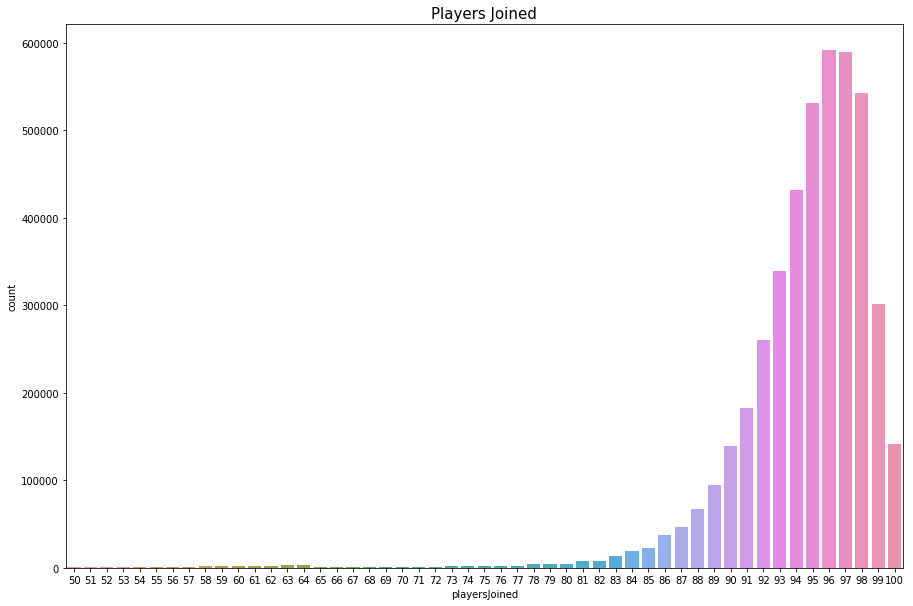

In [12]:
data = train_data.copy()
data = data[data['playersJoined']>49]
plt.figure(figsize=(15,10))
sns.countplot(data['playersJoined'])
plt.title("Players Joined",fontsize=15)
plt.show()

In [13]:
# We need to figure out how to standardize the data, each match has a different number of players,
# so we should normalize other features based on the amount of players.
# Based on the "playersJoined" feature we can create (or change) a lot of others to normalize their values. 
# For example we can, create the "killsNorm" and "damageDealtNorm" features. 
# When there are 100 players in the game it might be easier to find and kill someone, than when there are 90 players. 
# So we can normalize the kills in a way that a kill in 100 players will score 1 (as it is) and in 90 players it will 
# score (100-90)/100 + 1 = 1.1. This is just an assumption and different scales could be used.

train_data['killsNormalized'] = train_data['kills']*((100-train_data['playersJoined'])/100 + 1)
train_data['damageDealtNormalized'] = train_data['damageDealt']*((100-train_data['playersJoined'])/100 + 1)
train_data[['playersJoined', 'kills', 'killsNormalized', 'damageDealt', 'damageDealtNormalized']][5:8]

,playersJoined,kills,killsNormalized,damageDealt,damageDealtNormalized
5,95,1,1.05,100.000,105.00000
6,97,0,0.00,0.000,0.00000
7,96,0,0.00,8.538,8.87952


In [14]:
train_data.drop(['kills'], inplace=True, axis=1)
train_data.drop(['damageDealt'], inplace=True, axis=1)

train_dummy = train_data
#train_dummy.groupby(['matchId']).mean()
playerCount = train_dummy.groupby(['matchId']).count()
playerCount = playerCount["Id"].values
n, bins, patches = plt.hist(playerCount, bins=100)
#bins

print(("Mean player count: %d") % np.mean(playerCount))
print(("Median player count: %d") % np.ma.median(playerCount))
print(("Standard deviation of player count: %d") % np.std(playerCount))

scaledCount = [0]*len(playerCount)
i = 0
for x in playerCount:
    scaledCount[i] = ((x-np.mean(playerCount))/np.std(playerCount))
    i = i + 1
plt.hist(scaledCount, bins=100)
#Normal standardization probably isn't effective

# Categorical Variables

In [15]:
# Creating a column that determines if a player placed in the top 10 percent
train_data['winBinary'] = train_data['winPlacePerc']
def makeDummieVar(winPercent):
    if (winPercent >= 0.9):
        winPercent = 1
    else:
        winPercent = 0
    return winPercent

train_data['winBinary'] = train_data['winBinary'].apply(makeDummieVar)
train_data.head(5)

,Id,groupId,matchId,assists,boosts,DBNOs,headshotKills,heals,killPlace,killPoints,...,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,playersJoined,killsNormalized,damageDealtNormalized,winBinary
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0,0,0,60,1241,...,0,0,244.80,1,1466,0.4444,96,0.00,0.0000,0
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,0,0,0,57,0,...,0,0,1434.00,5,0,0.6400,91,0.00,99.7023,0
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,0,0,0,47,0,...,0,0,161.80,2,0,0.7755,98,0.00,69.3600,0
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,0,0,0,75,0,...,0,0,202.70,3,0,0.1667,91,0.00,35.8610,0
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,0,0,0,45,0,...,0,0,49.75,2,0,0.1875,97,1.03,103.0000,0


In [16]:
np.unique(train_data['matchType'])

array(['crashfpp', 'crashtpp', 'duo', 'duo-fpp', 'flarefpp', 'flaretpp',
       'normal-duo', 'normal-duo-fpp', 'normal-solo', 'normal-solo-fpp',
       'normal-squad', 'normal-squad-fpp', 'solo', 'solo-fpp', 'squad',
       'squad-fpp'], dtype=object)

In [17]:
# To make things less complicated, we should only look at standard matches.
# According to the given information, the standard modes are:
# “solo”, “duo”, “squad”, “solo-fpp”, “duo-fpp”, and “squad-fpp”.
# (The -fpp appeneded means the game forced all players to use a "first-person perspective",
# rather, than giving them the option between first-person and third-person to switch between.)
train_data = train_data[(train_data.matchType == 'solo') | (train_data.matchType == 'duo') |
                        (train_data.matchType == 'squad') | (train_data.matchType == 'solo-fpp') |
                        (train_data.matchType == 'duo-fpp') | (train_data.matchType == 'squad-fpp')]
np.unique(train_data['matchType'])

array(['duo', 'duo-fpp', 'solo', 'solo-fpp', 'squad', 'squad-fpp'],
      dtype=object)

In [18]:
sample = 5000
train_data = train_data.sample(sample)

In [19]:
# Drop Id column, because it probably won't be useful for our Machine Learning algorithm,
# because the test set contains different Id's
train_data.drop(['Id'], inplace=True, axis=1)

In [20]:
# Need to "One hot encode" the matchType feature to 
# perform “binarization” of the category and include it as a feature to train the model.
# This converts the categorical matchType variable into a form that could be provided to 
# ML algorithms to do a better job in prediction.

train_data = pd.get_dummies(train_data, columns=['matchType'])

In [21]:
# Taking a look at the encoding.
matchType_encoding = train_data.filter(regex='matchType')
matchType_encoding.head()

,matchType_duo,matchType_duo-fpp,matchType_solo,matchType_solo-fpp,matchType_squad,matchType_squad-fpp
2210796,0,0,0,1,0,0
3344254,1,0,0,0,0,0
2017212,0,0,0,0,0,1
3869751,0,0,0,0,1,0
1570200,0,1,0,0,0,0


In [22]:
# matchId's and groupId's are the other categorical variables. There are a ton of different ones so
# one hot encoding them makes no sense, but there could still be corrleations between them, as one
# match will have different charcteristics than the next, and the same goes for groups, so we should
# categorize them with Pandas.

In [23]:
train_data['groupId'] = train_data['groupId'].astype('category')
train_data['matchId'] = train_data['matchId'].astype('category')

# Get category coding for groupId and matchID
train_data['groupId_cat'] = train_data['groupId'].cat.codes
train_data['matchId_cat'] = train_data['matchId'].cat.codes

# Get rid of old columns
train_data.drop(['groupId', 'matchId'], inplace=True, axis=1)

train_data[['groupId_cat', 'matchId_cat']].head()

,groupId_cat,matchId_cat
2210796,4391,2992
3344254,3560,884
2017212,1544,3427
3869751,4436,3037
1570200,4213,1400


# Feature Selection

In [24]:
# from sklearn.linear_model import LogisticRegression
# logReg = LogisticRegression()

In [26]:
wpp = train_data['winPlacePerc']
train_data.drop(labels=['winPlacePerc'], axis=1,inplace = True)
train_data.insert(34, 'winPlacePerc', wpp)
wb = train_data['winBinary']

In [27]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 2210796 to 3522731
Data columns (total 35 columns):
assists                  5000 non-null int64
boosts                   5000 non-null int64
DBNOs                    5000 non-null int64
headshotKills            5000 non-null int64
heals                    5000 non-null int64
killPlace                5000 non-null int64
killPoints               5000 non-null int64
killStreaks              5000 non-null int64
longestKill              5000 non-null float64
matchDuration            5000 non-null int64
maxPlace                 5000 non-null int64
numGroups                5000 non-null int64
rankPoints               5000 non-null int64
revives                  5000 non-null int64
rideDistance             5000 non-null float64
roadKills                5000 non-null int64
swimDistance             5000 non-null float64
teamKills                5000 non-null int64
vehicleDestroys          5000 non-null int64
walkDistance           

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesRegressor

# Take sample for debugging and exploration
#sample = 50000
#df_sample = train_data.sample(sample)
df_sample = train_data

In [29]:
df_sample = train_data
#lr_sample = train_data

In [30]:
# Split sample into training data and target variable
X = df_sample.drop(['winPlacePerc', 'winBinary'], inplace=False, axis=1) #all columns except target.
y = df_sample['winPlacePerc'] # Only target variable

#Xlr = lr_sample.drop(['winPlacePerc', 'winBinary'], inplace=False, axis=1)
#ylr = df_sample['winBinary']
#Xlr_train, Xlr_test, ylr_train, ylr_test = train_test_split(Xlr, ylr, test_size=0.3, random_state=22,shuffle=True)

In [31]:
model_rfe = LogisticRegression()
rfe = RFE(model_rfe, 1)
X_int = X.astype('int')
y_int = (y * 100).astype('int')
fit = rfe.fit(X_int,y_int)
featureNames = [0] * len(X_int.columns)
for f in range(len(X_int.columns)):
    featureNames[f] = list(X_int)[f]
print("Feature Ranking, From Recursive Feature Elimination:")
rfeRanks = pd.DataFrame({'ranking':fit.ranking_,'feature':featureNames})
rfeRanks = rfeRanks.sort_values('ranking')
rfeRanks['feature'].reset_index(drop=True, inplace=True)
for f in range(0, len(list(X_int))):
    print("%d. %s" % (f + 1, rfeRanks['feature'][f]))

Feature Ranking, From Recursive Feature Elimination:
1. boosts
2. matchType_squad-fpp
3. matchType_squad
4. matchType_duo-fpp
5. matchType_duo
6. matchType_solo-fpp
7. matchType_solo
8. teamKills
9. revives
10. killStreaks
11. assists
12. vehicleDestroys
13. headshotKills
14. killsNormalized
15. DBNOs
16. weaponsAcquired
17. roadKills
18. heals
19. swimDistance
20. maxPlace
21. numGroups
22. playersJoined
23. killPlace
24. longestKill
25. rideDistance
26. walkDistance
27. damageDealtNormalized
28. winPoints
29. rankPoints
30. killPoints
31. matchDuration
32. matchId_cat
33. groupId_cat


In [32]:
len(X_int.columns)

33

In [33]:
len(fit.ranking_)

33

In [34]:
#for f in range(len(fit.support_)):
#   if fit.support_[f] == True:
#      print featureNames[f]

Automatically created module for IPython interactive environment
Optimal number of features : 31


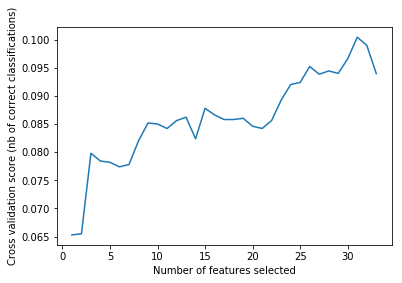

In [35]:
print(__doc__)

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV

#y_int = (y * 100).astype('int')

# Create the RFE object and compute a cross-validated score.
#svc = SVC(kernel="linear")
#LRCV = LogisticRegressionCV()
# The "accuracy" scoring is proportional to the number of correct
# classifications
rfecv = RFECV(model_rfe, cv=StratifiedKFold(2), scoring='accuracy')
rfecv_fit = rfecv.fit(X_int,y_int)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [36]:
rfecv.ranking_

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 2])

In [37]:
featureNames_cv = [0] * len(rfecv_fit.ranking_)
for f in range(len(rfecv_fit.ranking_)):
    featureNames_cv[f] = list(X_int)[f]
print("Feature Ranking, From Recursive Feature Elimination:")
rfeCVRanks = pd.DataFrame({'ranking':rfecv_fit.ranking_,'feature':featureNames_cv})
rfeCVRanks = rfeCVRanks.sort_values('ranking')
rfeCVRanks['feature'].reset_index(drop=True, inplace=True)
for f in range(0, len(list(featureNames_cv))):
    print("%d. %s" % (f + 1, rfeCVRanks['feature'][f]))

Feature Ranking, From Recursive Feature Elimination:
1. assists
2. matchType_squad-fpp
3. matchType_squad
4. matchType_solo-fpp
5. matchType_solo
6. matchType_duo-fpp
7. matchType_duo
8. damageDealtNormalized
9. killsNormalized
10. playersJoined
11. winPoints
12. weaponsAcquired
13. walkDistance
14. vehicleDestroys
15. teamKills
16. swimDistance
17. killStreaks
18. rideDistance
19. revives
20. rankPoints
21. numGroups
22. maxPlace
23. matchDuration
24. longestKill
25. roadKills
26. killPoints
27. killPlace
28. heals
29. headshotKills
30. DBNOs
31. boosts
32. matchId_cat
33. groupId_cat


# USE THE TOP FEATURES FROM RFECV IN THE RFR

In [38]:
#Using the top "#" features from the cross-validated recursive feature selection

In [39]:
# Metric used for the PUBG competition (Mean Absolute Error (MAE))
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
# mae is the criteron for the dataset
rfr = RandomForestRegressor(max_depth=500,criterion='mae',
                            max_features=None,n_estimators=75,bootstrap=True,
                            min_samples_leaf=1,n_jobs=1,min_samples_split=2)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=22,shuffle=True)
print('X_train.shape %s, X_test.shape %s\ny_train.shape %s, y_test.shape %s'%(X_train.shape,X_test.shape,y_train.shape,y_test.shape))
rfr.fit(X_train,y_train)

X_train.shape (3500, 33), X_test.shape (1500, 33)
y_train.shape (3500,), y_test.shape (1500,)


RandomForestRegressor(bootstrap=True, criterion='mae', max_depth=500,
           max_features=None, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=75, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [40]:
#print_score(rfr)
res = ['mae train: ', mean_absolute_error(rfr.predict(X_train), y_train), 
           'mae val: ', mean_absolute_error(rfr.predict(X_test), y_test)]
if hasattr(rfr, 'oob_score_'): res.append(rfr.oob_score_)
print(res)

['mae train: ', 0.026483187047619035, 'mae val: ', 0.07015004222222222]


In [41]:
from sklearn.metrics import mean_squared_error, r2_score
y_pred_rfr = rfr.predict(X_test)
# r2_score score: 1 is perfect prediction
rfr_score=r2_score(y_pred=y_pred_rfr,y_true=y_test)
print("Variance score (r2_score): %f"%rfr_score)
print('Model accuracy:%.2f '%(rfr_score*100))

Variance score (r2_score): 0.892058
Model accuracy:89.21 


In [42]:
RFpredictions = pd.DataFrame(data=y_pred_rfr)
frames = [RFpredictions, y_test.reset_index().iloc[:,1]]
modelTest = pd.concat(frames, axis=1)
modelTest.columns = ["Random Forest Predicted", "Actual"]
modelTest.head(10)

,Random Forest Predicted,Actual
0,0.479865,0.4444
1,0.228153,0.2222
2,0.544495,0.5556
3,0.329921,0.3617
4,0.896028,0.8846
5,0.311221,0.2692
6,0.338520,0.3830
7,0.956488,0.8214
8,0.434513,0.5319
9,0.052537,0.0737


Feature ranking, from Random Forest Regressor:
1. assists (0.531319)
2. boosts (0.199943)
3. DBNOs (0.031553)
4. headshotKills (0.027151)
5. heals (0.022056)
6. killPlace (0.020523)
7. killPoints (0.018594)
8. killStreaks (0.015340)
9. longestKill (0.014247)
10. matchDuration (0.012197)
11. maxPlace (0.011391)
12. numGroups (0.010588)
13. rankPoints (0.010258)
14. revives (0.009861)
15. rideDistance (0.008371)
16. roadKills (0.008335)
17. swimDistance (0.008320)
18. teamKills (0.007387)
19. vehicleDestroys (0.007300)
20. walkDistance (0.004294)
21. weaponsAcquired (0.003096)
22. winPoints (0.002668)
23. playersJoined (0.002664)
24. killsNormalized (0.002079)
25. damageDealtNormalized (0.001857)
26. matchType_duo (0.001855)
27. matchType_duo-fpp (0.001844)
28. matchType_solo (0.001501)
29. matchType_solo-fpp (0.000995)
30. matchType_squad (0.000920)
31. matchType_squad-fpp (0.000770)
32. groupId_cat (0.000465)
33. matchId_cat (0.000257)


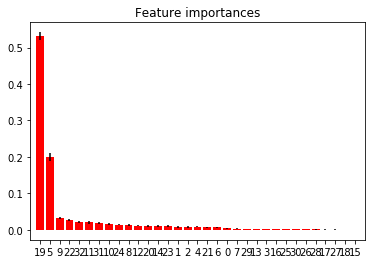

In [43]:
importances = rfr.feature_importances_
std = np.std([tree.feature_importances_ for tree in rfr.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking, from Random Forest Regressor:")

for f in range(X.shape[1]):
    print("%d. %s (%f)" % (f + 1, featureNames[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

for f in range(len(fit.ranking_)):
    if fit.ranking_[f] == 1:
        print featureNames[f]

In [50]:
X_train_int = X_train.astype('int')
X_test_int = X_test.astype('int')
y_train_int = (y_train * 100).astype('int')
y_test_int = (y_test * 100).astype('int')

In [45]:
from sklearn.linear_model import LogisticRegression
logReg = LogisticRegression()

In [51]:
logReg.fit(X_train_int, y_train_int)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [52]:
yp = logReg.predict(X_test_int)

In [53]:
from sklearn.metrics import confusion_matrix
confusion_m = confusion_matrix(y_test_int, yp)
confusion_m
#1319+75 = 1394 correct predictions
#33+73 = 106 incorrect predictions



array([[71,  2,  2, ...,  0,  0,  0],
       [ 1,  1,  1, ...,  0,  0,  0],
       [ 6,  1,  5, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ...,  0,  0,  1],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 1,  0,  0, ...,  0,  0, 22]], dtype=int64)

In [54]:
from __future__ import division

In [55]:
accuracy = (confusion_m[0,0]+confusion_m[1,1])/sum(map(sum, confusion_m))
print(accuracy)
#print(("Percent Accuracy: %d") % accuracy)

0.048


In [56]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [59]:
lra = roc_auc_score(y_test_int, yp)
fpr, tpr, thresholds = roc_curve(y_test_int, logReg.predict_proba(X_test_int)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % lra)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()
#Logistic Regression Model significantly better at predicting a top 10% finish than random guessing

ValueError: continuous format is not supported

In [ ]:
lr_score = r2_score(y_test_int, yp)
print("Variance score (r2_score): %f"%lr_score)

In [ ]:
LRpredictions = pd.DataFrame(data=yp)
frames = [LRpredictions, y_test_int.reset_index().iloc[:,1]]
modelTest = pd.concat(frames, axis=1)
modelTest.columns = ["Logistic Regression Predicted", "Actual"]
modelTest.head(15)

f,ax = plt.subplots(figsize=(15, 15))
sns.heatmap(train_data.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)
plt.show()

In [ ]:
import statsmodels.api as sm

In [ ]:
model = sm.Logit(y_train_int, X_train_int) 
result = model.fit()

In [ ]:
result.summary()

In [ ]:
result.aic